# Facebook Prophet: Univariate and Multivariate Analysis

https://facebook.github.io/prophet/docs/quick_start.html

Pre-requisites:
- pystan
- prophet

In [71]:
from prophet import Prophet
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [72]:
df_train = pd.read_csv('../data_sets/DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('../data_sets/DailyDelhiClimateTest.csv')

In [73]:
len(df_train)

1462

In [74]:
len(df_test)

114

In [75]:
df_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


## Univariate Forecasting

In [76]:
df_train = df_train.rename(columns={'meantemp': 'y', 'date': 'ds'})
df_train['y_orig'] = df_train['y']
df_train['y'] = np.log(df_train['y']) # basic log transformation to make data stationary.

# In Facebook Prophet, default to log transformation.

# only using date to predict mean temperature

In [77]:
df_train.head()
# verify y_orig preserved original meantemp data, and meantemp transformed to log and renamed 'y'

,ds,y,humidity,wind_speed,meanpressure,y_orig
0,2013-01-01,2.302585,84.500000,0.000000,1015.666667,10.000000
1,2013-01-02,2.001480,92.000000,2.980000,1017.800000,7.400000
2,2013-01-03,1.969441,87.000000,4.633333,1018.666667,7.166667
3,2013-01-04,2.159484,71.333333,1.233333,1017.166667,8.666667
4,2013-01-05,1.791759,86.833333,3.700000,1016.500000,6.000000


In [78]:
# Instantiate Prophet model

model = Prophet()
model.fit(df_train)

17:02:35 - cmdstanpy - INFO - Chain [1] start processing
17:02:35 - cmdstanpy - INFO - Chain [1] done processing


In [79]:
# Daily prediction for the next 513 days

future_data = model.make_future_dataframe(periods=513, freq='D')
forecast_data = model.predict(future_data)

In [80]:
#forecast_data.head()
# yhat = predicted, and upper and lower ranges of prediction
forecast_data[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1970,2018-05-25,3.741451,3.471070,3.979833
1971,2018-05-26,3.738539,3.460966,3.997931
1972,2018-05-27,3.734789,3.456985,3.996220
1973,2018-05-28,3.748972,3.467754,4.007512
1974,2018-05-29,3.754522,3.482366,3.998140


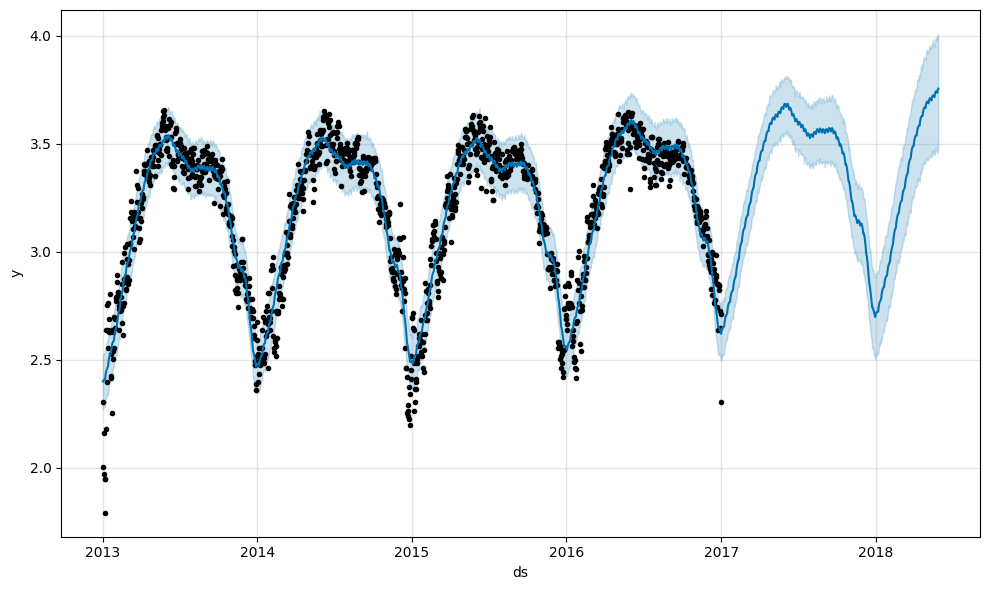

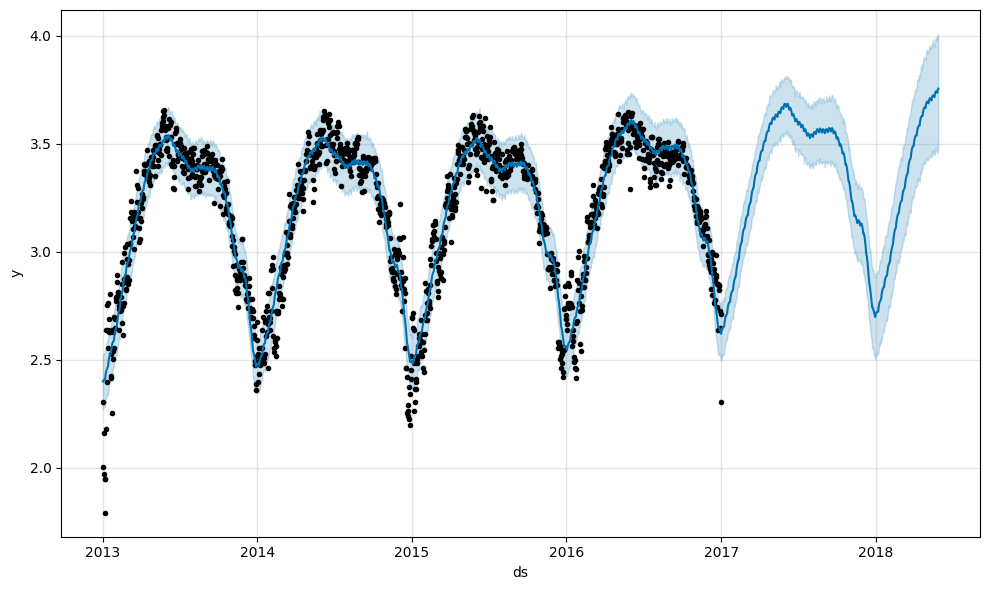

In [81]:
model.plot(forecast_data)

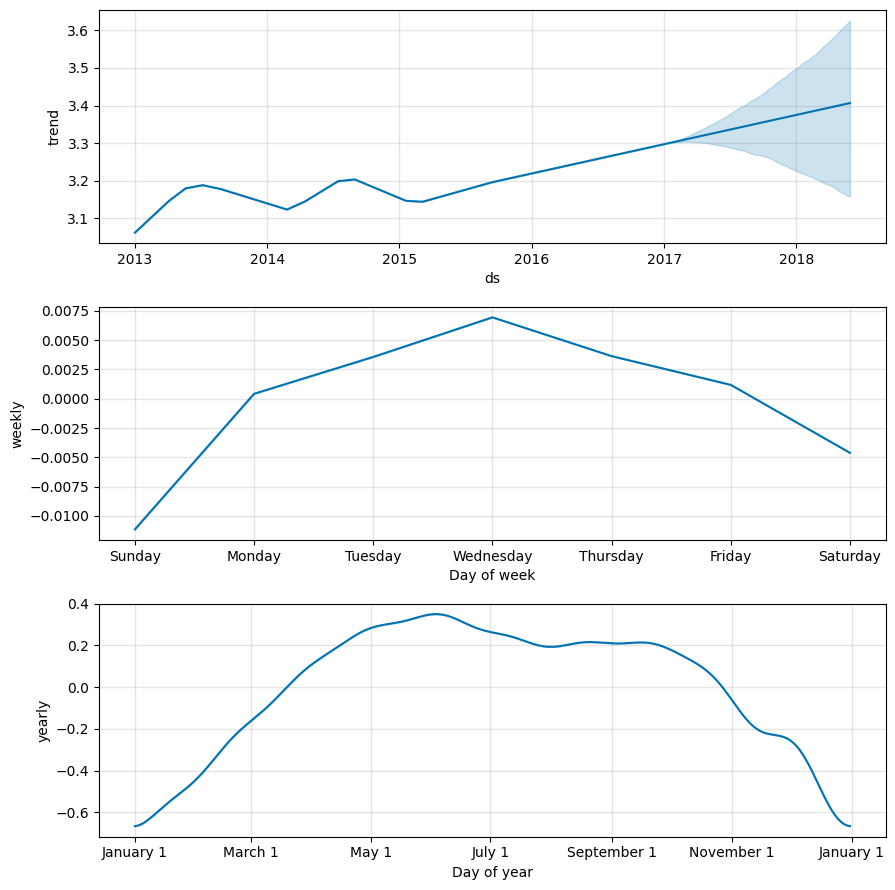

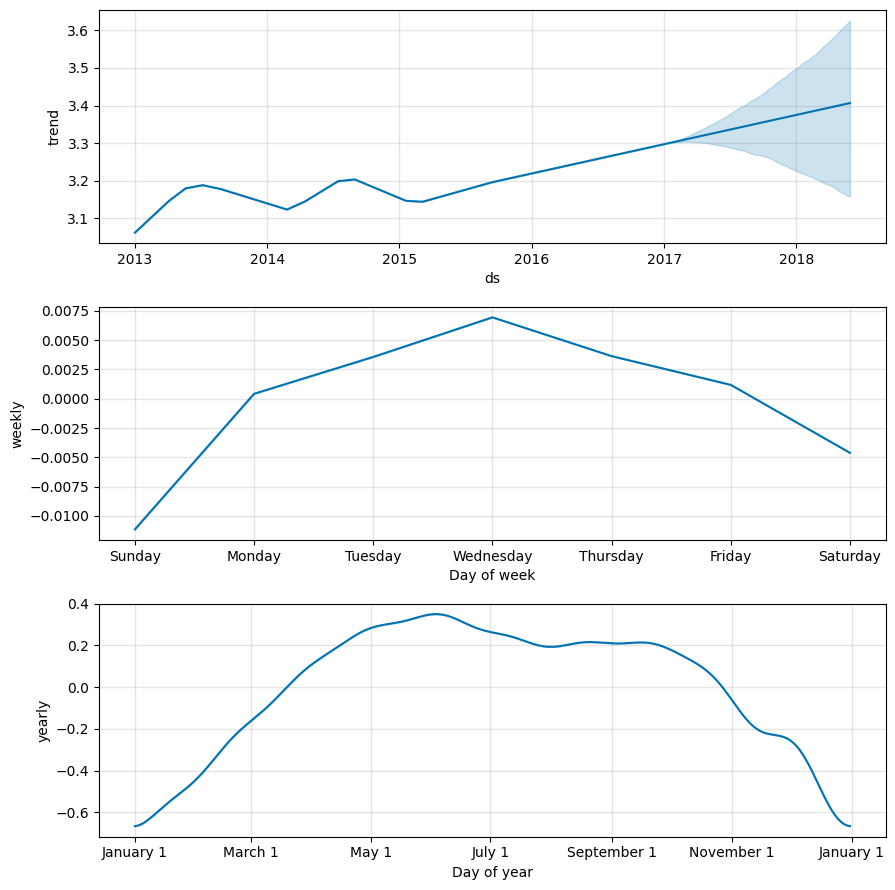

In [82]:
model.plot_components(forecast_data)

In [83]:
# Need to do inverse transformation, because current predictions are on log transformed data

forecast_data_orig = forecast_data # make sure to save the original forecast data
forecast_data_orig['yhat'] = np.exp(forecast_data_orig['yhat'])
forecast_data_orig['yhat_lower'] = np.exp(forecast_data_orig['yhat_lower'])
forecast_data_orig['yhat_upper'] = np.exp(forecast_data_orig['yhat_upper'])

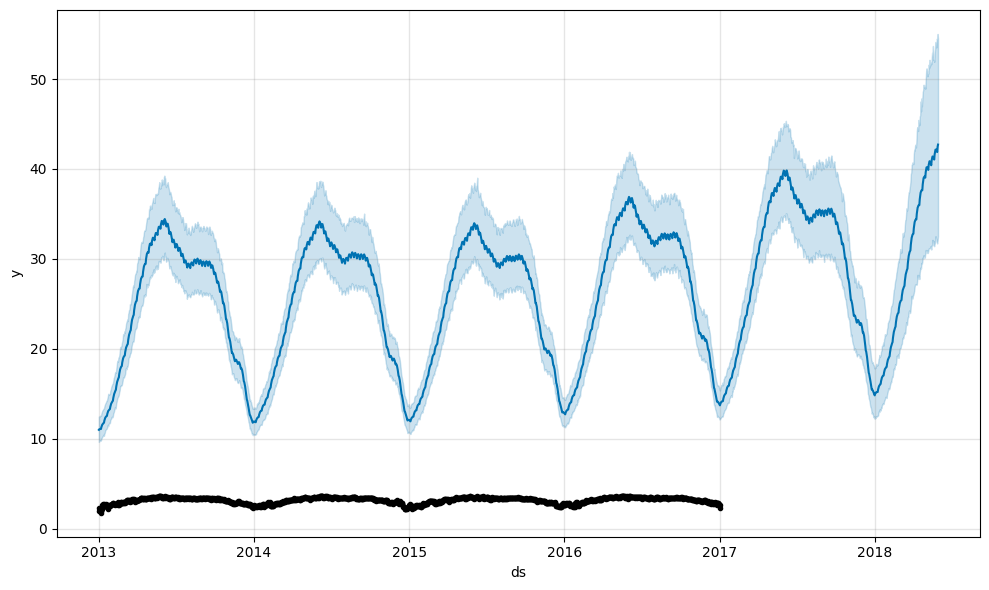

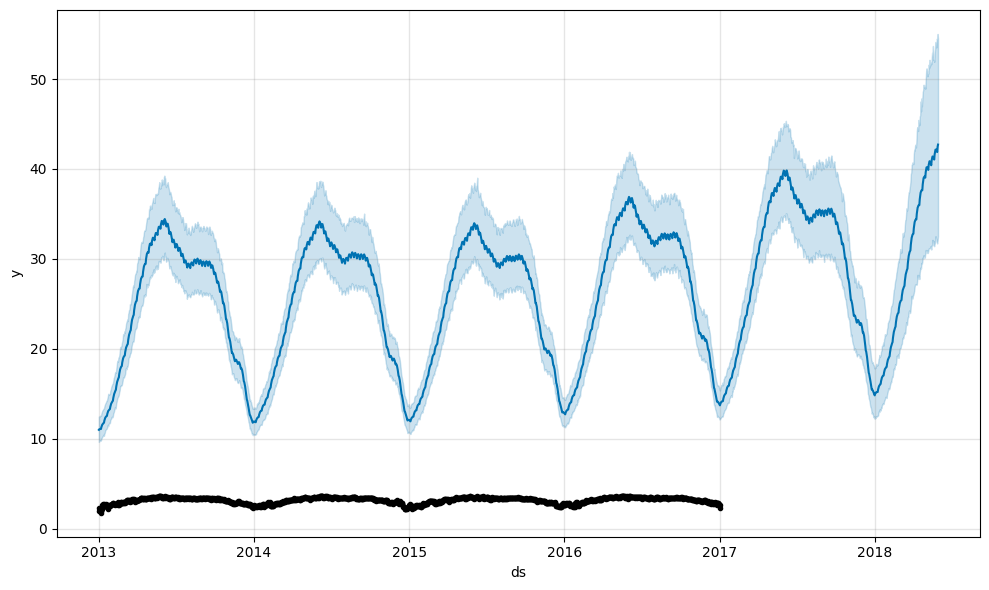

In [84]:
model.plot(forecast_data_orig)

In [85]:
# Copy the log transformed data to another column

df_train['y_log'] = df_train['y']
df_train[''] = df_train['y_orig']

In [86]:
# Plot predicted and actual line graph with X = dates and y = outbound

final_df = pd.DataFrame(forecast_data_orig)
import plotly.graph_objs as go
import plotly.offline as py

actual_chart = go.Scatter(y=df_train['y_orig'], name = 'Actual')
predict_chart = go.Scatter(y=final_df['yhat'], name = 'Predicted')
predict_chart_upper = go.Scatter(y=final_df['yhat_upper'], name = 'Predicted Upper')
predict_chart_lower = go.Scatter(y=final_df['yhat_lower'], name = 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower])

'temp-plot.html'

In [87]:
# You can see the prediction does not get the sharp edges (peak and valley volatility), 
# but it gets the average pretty well.

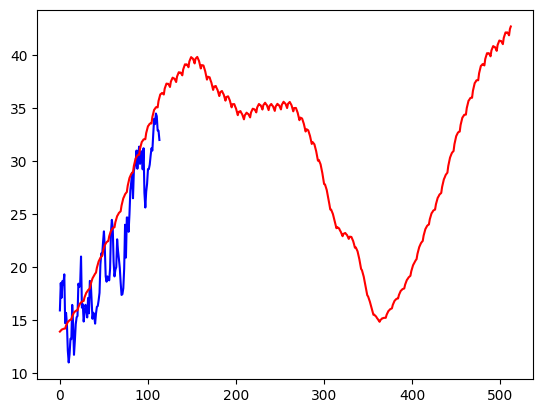

In [88]:
# Plot testing data with the predicted data

rows = final_df['yhat'].tail(513)
rows = rows.reset_index()
rows.pop('index')

import matplotlib.pyplot as plt
plt.plot(df_test['meantemp'], color = 'blue')
plt.plot(rows, color='red')
plt.show()

## Multivariate Forecasting

In [89]:
# Everything is the same as above, up through the logarithmic transformation

df_train.head()

# instead of meantemp as the only X variable, now we will also use humidity, wind_speed, and meanpressure
# use add_regressor() to do this

model_new = Prophet()

for reg in ['humidity', 'wind_speed', 'meanpressure']:
    model_new.add_regressor(reg)


In [90]:
model_new.fit(df_train)

17:02:36 - cmdstanpy - INFO - Chain [1] start processing
17:02:36 - cmdstanpy - INFO - Chain [1] done processing


In [91]:
future_data = model_new.make_future_dataframe(periods=513, freq='D')

In [92]:
future_data.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [93]:
df_train = df_train.rename(columns={'date': 'ds', 'meantemp': 'y'})
df_test  = df_test.rename(columns={'date': 'ds', 'meantemp': 'y'})

df = pd.concat([df_train, df_test], ignore_index=True)


df = pd.concat([df_train, df_test])
df = df.rename(columns={'meantemp': 'y', 'date': 'ds'})
future_data = df[['ds', 'humidity', 'wind_speed', 'meanpressure']]

future_data.head()

,ds,humidity,wind_speed,meanpressure
0,2013-01-01,84.500000,0.000000,1015.666667
1,2013-01-02,92.000000,2.980000,1017.800000
2,2013-01-03,87.000000,4.633333,1018.666667
3,2013-01-04,71.333333,1.233333,1017.166667
4,2013-01-05,86.833333,3.700000,1016.500000


In [94]:
# The rest is all the same as univariate

In [95]:
forecast_data = model_new.predict(future_data)

forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1571,2017-04-20,3.573943,3.464897,3.681442
1572,2017-04-21,3.522290,3.418006,3.634998
1573,2017-04-22,3.518209,3.410086,3.615680
1574,2017-04-23,3.577918,3.464505,3.692963
1575,2017-04-24,3.588786,3.485115,3.694524


In [96]:
forecast_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,wind_speed,wind_speed_lower,wind_speed_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,3.043930,2.252245,2.474583,3.043930,3.043930,-0.688170,-0.688170,-0.688170,-0.102892,...,0.009690,0.009690,0.009690,-0.587938,-0.587938,-0.587938,0.0,0.0,0.0,2.355760
1,2013-01-02,3.044936,2.215553,2.429204,3.044936,3.044936,-0.723898,-0.723898,-0.723898,-0.142727,...,0.005445,0.005445,0.005445,-0.584817,-0.584817,-0.584817,0.0,0.0,0.0,2.321038
2,2013-01-03,3.045942,2.238966,2.444529,3.045942,3.045942,-0.703264,-0.703264,-0.703264,-0.121373,...,0.003090,0.003090,0.003090,-0.580422,-0.580422,-0.580422,0.0,0.0,0.0,2.342678
3,2013-01-04,3.046949,2.326001,2.535969,3.046949,3.046949,-0.616832,-0.616832,-0.616832,-0.042210,...,0.007933,0.007933,0.007933,-0.574901,-0.574901,-0.574901,0.0,0.0,0.0,2.430116
4,2013-01-05,3.047955,2.254347,2.467391,3.047955,3.047955,-0.686592,-0.686592,-0.686592,-0.119237,...,0.004419,0.004419,0.004419,-0.568413,-0.568413,-0.568413,0.0,0.0,0.0,2.361362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,2017-04-20,3.308463,3.464897,3.681442,3.295419,3.322749,0.265480,0.265480,0.265480,0.159675,...,0.001766,0.001766,0.001766,0.107273,0.107273,0.107273,0.0,0.0,0.0,3.573943
1572,2017-04-21,3.308662,3.418006,3.634998,3.295433,3.323186,0.213627,0.213627,0.213627,0.101346,...,-0.000228,-0.000228,-0.000228,0.112002,0.112002,0.112002,0.0,0.0,0.0,3.522290
1573,2017-04-22,3.308861,3.410086,3.615680,3.295383,3.323643,0.209348,0.209348,0.209348,0.091354,...,-0.002974,-0.002974,-0.002974,0.116937,0.116937,0.116937,0.0,0.0,0.0,3.518209
1574,2017-04-23,3.309060,3.464505,3.692963,3.295350,3.324078,0.268858,0.268858,0.268858,0.153380,...,-0.004502,-0.004502,-0.004502,0.122028,0.122028,0.122028,0.0,0.0,0.0,3.577918


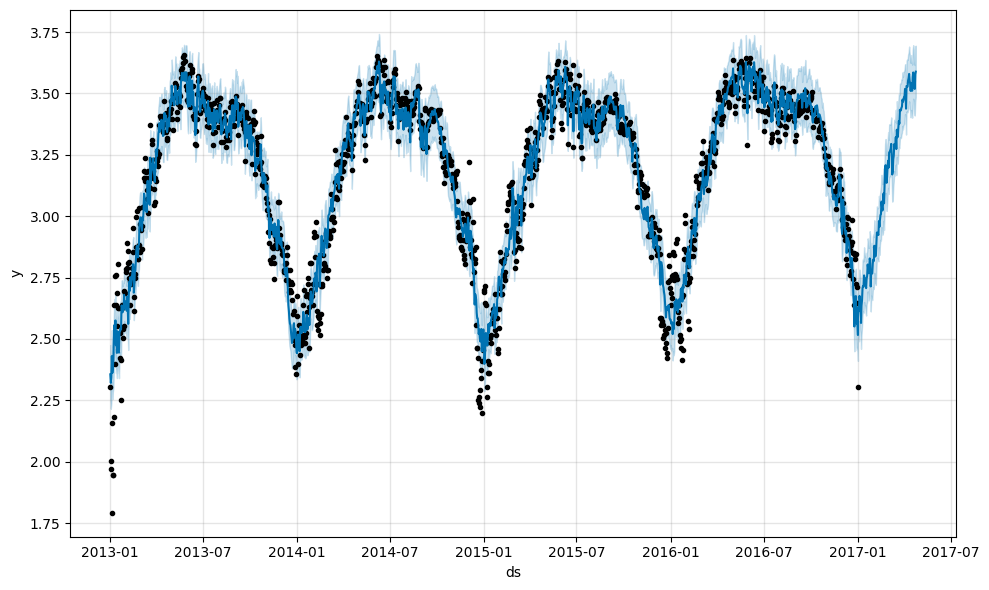

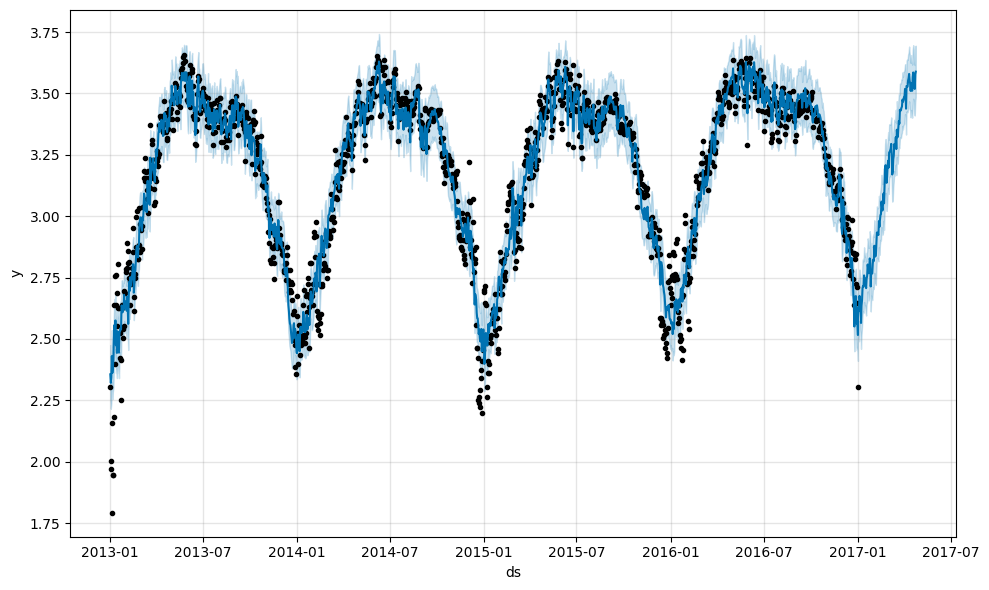

In [97]:
model_new.plot(forecast_data)

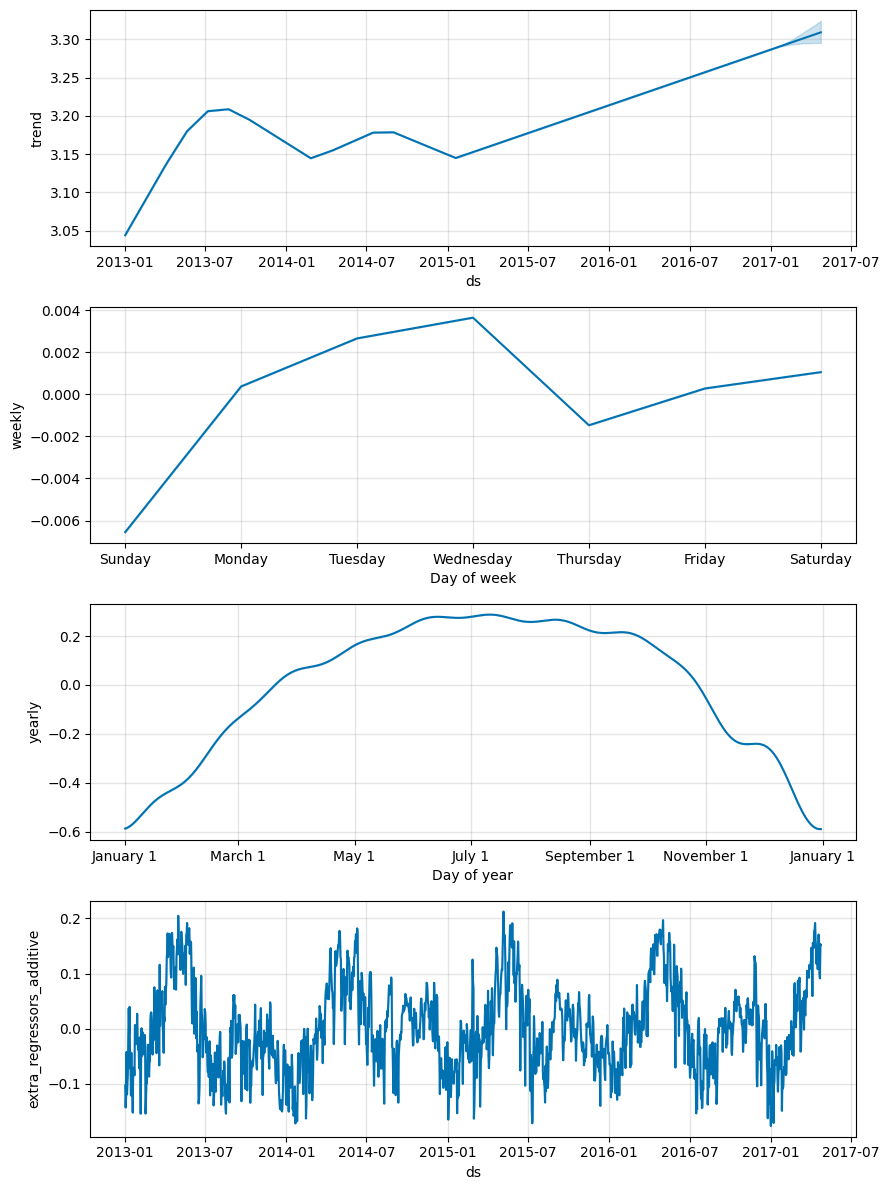

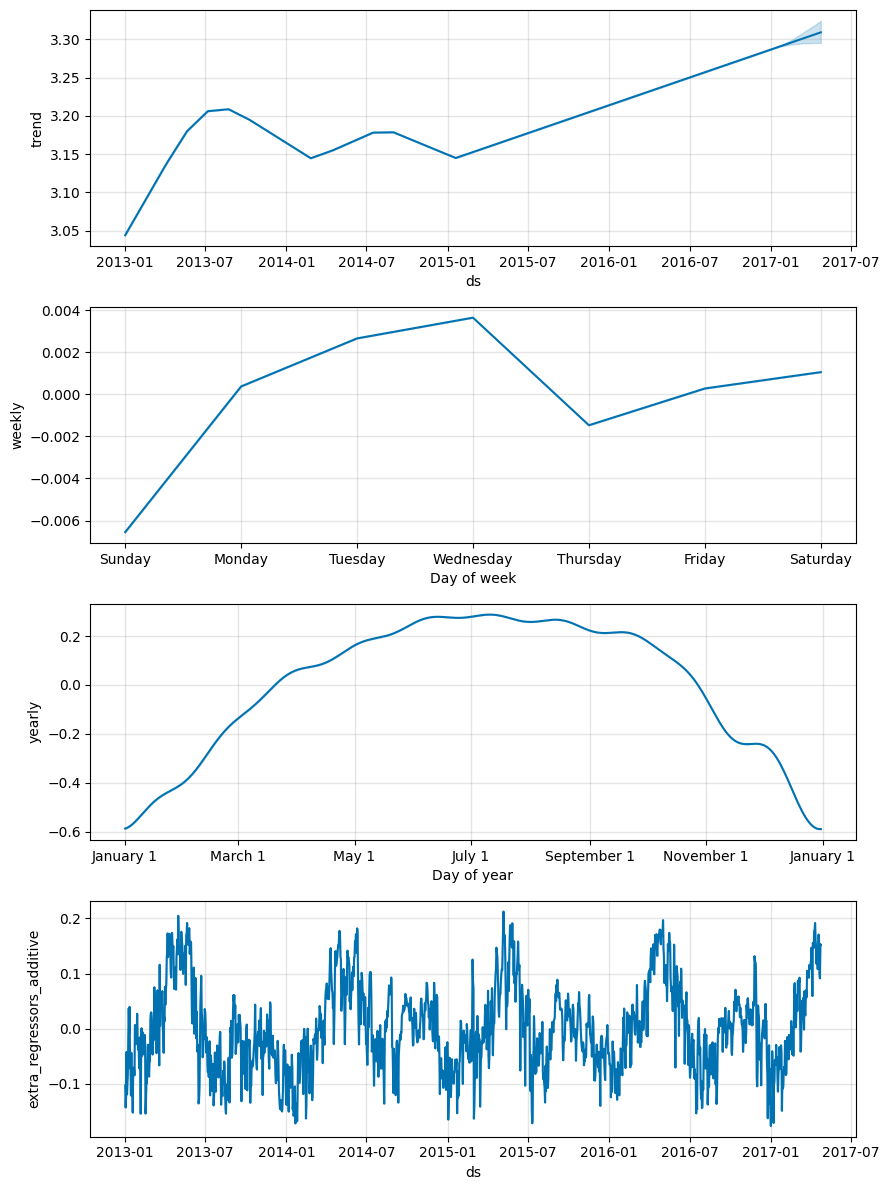

In [98]:
model_new.plot_components(forecast_data)

In [99]:
# additive and multiplicative decomposition

The only difference is the add_regressor() part. Compare the difference between the prediction line. You can see there is a lot more volatility predicted.